# Google Analytics Customer Revenue Prediction
***
#### By Armand Kok and Adam Yang<br>UC Berkeley<br>w207 Applied Machine Learning Fall 2018

## Introduction

The motivation and data utlized in this project was based off of a Kaggle competition titled *Google Analytics Customer Revenue Prediction* (https://www.kaggle.com/c/ga-customer-revenue-prediction). Google argues that the 80/20 rule where only a small percentage of the customers generate the majority of the revenue, is proven to be true for many businesses. Because of this, it would be beneficial to be able to predict the amount of revenue that a certain customer would contribute to your business based off of meta data collected from their online visit. Being able to identify the small percentage of customers that generate the majority of the revenue may motivate some actionable operational and marketing strategies to target these customers.  

For the purpose of this project, we will be using data provided from the online Google Merchandise Store (where Google swag is sold) to predict the revenue generated from each customer.

**Task:**<br>
Analyze Google Merchandise Store customer dataset to predict revenue per customer (how much money each customer ends up paying).

**Purpose:**<br>
Help figure out what is the ideal way of organizing marketing budgets to target the customers who contribute the most to the revenue.

**Details:**<br>
Each customer will be tracked by their `fullVisitorId` and the value that we aim to estimate is the `predictedLogRevenue` of each customer. To create training labels to fit the models we create, we would have to calculate the `predictedLogRevenue` by summing up all of the `transactionRevenue` values for each `fullVisitorId` and then taking the natural log (we add 1 within the natural log in case any of the customers contributed zero dollars in revenue).

$$totalTransactionRevenue_{user} = \sum_{i = 1}^{n}transactionRevenue_{user_i}$$
$$predictedLogRevenue_{user} = \ln{(totalTransactionRevenue_{user} + 1)}$$

<br>The model performance will be measured by Root Mean Squared Error (RMSE):

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y_i})^2}$$
where $\hat{y}$ is the predicted revenue for a customer for a customer and $y$ is the natural log of the actual summed revenue value plus one.


##### The Data Field (as provided by the kaggle posting)

- **fullVisitorId**: A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping**: The channel via which the user came to the Store.
- **date**: The date on which the user visited the Store.
- **device**: The specifications for the device used to access the Store.
- **geoNetwork**: This section contains information about the geography of the user.
- **socialEngagementType**: Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals**: This section contains aggregate values across the session.
- **trafficSource**: This section contains information about the Traffic Source from which the session originated.
- **visitId**: An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber**: The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime**: The timestamp (expressed as POSIX time).
- **hits**: This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- **customDimensions**: This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- **totals**: This set of columns mostly includes high-level aggregate data.

***Each Row in the data set is a single online visit to the Google Merchandise Store***

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import ast
import json
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
from scipy import stats 
import imblearn

plt.style.use('seaborn') 

# Deal with annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn stuff
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import feature_selection
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import pipeline

## Load Data

In [2]:
# Download the data through Kaggle API (iOS)
! kaggle competitions download -c ga-customer-revenue-prediction

 79%|█████████████████████████████▊        | 2.00M/2.55M [00:00<00:00, 5.36MB/s]
100%|██████████████████████████████████████| 2.55M/2.55M [00:00<00:00, 6.86MB/s]
100%|███████████████████████████████████████▉| 304M/304M [00:51<00:00, 6.04MB/s]
100%|████████████████████████████████████████| 304M/304M [00:51<00:00, 6.24MB/s]
100%|█████████████████████████████████████▉| 1.03G/1.03G [02:53<00:00, 6.32MB/s]
100%|██████████████████████████████████████| 1.03G/1.03G [02:53<00:00, 6.39MB/s]


You can either manually unzip the file or use the following code to unzip it.

In [7]:
# First you have to make sure the unzip command is installed in your computer. (iOS)
! apt-get install unzip

/bin/sh: apt-get: command not found


In [3]:
# Next, use the unzip command to unzip the file. (iOS)
! unzip train_v2.csv.zip

Archive:  train_v2.csv.zip
  inflating: train_v2.csv            


In [12]:
#  IMPORTANT: Due to the formatting of fullVisitorId you must load 
# the Id's as strings in order for all Id's to be properly unique! 
df = pd.read_csv('train_v2.csv', dtype={'fullVisitorId': str})

In [3]:
# Take a look at our data
df.head(5)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


As shown above, the raw data we are working with is very messy. There are embedded dictionaries within many of the columns such as the `device` and `geoNetwork` columns. Other columns such as `hits` and `customDimensions` even have a list of columns embedded within. Therefore, we will have to do a lot of data wranglling to clean up this data set and make it easier to train with. Furthermore, we will have to pull out the `transactionRevenue` parameter from the `totals` column in order to calculate the `predictedLogRevenue` that we will use as our training label. Furthermore, we will have to aggregate the data by their `fullVisitorId` so that we can train the data per each visitor rather than each transaction.

## Data Wrangling

### Creating a Smaller Training Set

The traning data set that we pullled from Kaggle consists of 1,708,337 rows of transactions which is about 25GB of data. For the sake of faster training and reducing the stress on our computers, we will plan on randomly pulling 10% of the unique `fullVisitorIds` as our training set. We will call this smaller training set `train_simple`.

In [13]:
# Find all of the unique fullVisitorId from the df and store it into visitor_id_list
visitor_id_list = pd.Series(df.fullVisitorId.unique())
# Update the visitor_id_list by randomly sampling 10% of the unique fullVisitorId from the list
# The random seed is set to 207 in honor of this class so that our data doesn't change.
visitor_id_list = visitor_id_list.sample(n=int(0.10 * len(visitor_id_list)), random_state=207)

# Create train_simple that holds only 10% of the unique fullVisitorIds
train_simple = df[df.fullVisitorId.isin(visitor_id_list)].copy().reset_index()

### Data Cleaning

The `device`, `geoNetwork`, `totals`, and `trafficSource` columns in our data frame are in a json format. We will parse through these columns and transform each key into a column of its own.

In [14]:
# Parse json columns and 
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

for col in json_cols:
    train_simple = train_simple.join(train_simple
                                     .pop(col)
                                     .apply(lambda x: pd.Series(json.loads(x))),
                                     rsuffix=str('_'+col))
# Delete the "index" column because it is the original index from the training set we sampled from.
# This shouldn't be relevant for figuring out the revenue contributions.
del train_simple['index']

In [6]:
# Take a look at our new train_simple dataframe
train_simple.head(5)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,browser,...,totalTransactionRevenue,bounces,campaign,source,medium,adwordsClickInfo,isTrueDirect,referralPath,keyword,adContent
0,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,NaN,NaN,(not set),(direct),(none),{'criteriaParameters': 'not available in demo ...,True,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'APAC'}]",20171016,8603113812592998660,"[{'hitNumber': '1', 'time': '0', 'hour': '19',...",Not Socially Engaged,1508206196,1,1508206196,Chrome,...,NaN,NaN,(not set),blog.golang.org,referral,{'criteriaParameters': 'not available in demo ...,NaN,/gopher,NaN,NaN
2,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,0303004412542706127,"[{'hitNumber': '1', 'time': '0', 'hour': '13',...",Not Socially Engaged,1508184007,1,1508184007,Chrome,...,NaN,NaN,(not set),(direct),(none),{'criteriaParameters': 'not available in demo ...,NaN,/,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20171016,7430057487980759848,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508188980,1,1508188980,Chrome,...,NaN,NaN,(not set),google,organic,{'criteriaParameters': 'not available in demo ...,NaN,NaN,(not provided),NaN
4,Paid Search,"[{'index': '4', 'value': 'North America'}]",20171016,9313911943042504128,"[{'hitNumber': '1', 'time': '0', 'hour': '16',...",Not Socially Engaged,1508198332,1,1508198332,Chrome,...,NaN,NaN,AW - Dynamic Search Ads Whole Site,google,cpc,"{'page': '1', 'slot': 'Top', 'criteriaParamete...",NaN,NaN,1hZbAqLCbjwfgOH7,NaN


In [15]:
# For quicker loading times we will write train_simple into a csv file
train_simple.to_csv('train_simple.csv', index = False)

In [2]:
# For quicker loading times, you can directly load the train_simple.csv file
train_simple = pd.read_csv('train_simple.csv', dtype={'fullVisitorId': str})

**The Messy `hits` Column**

First we are going to address the `hits` column. Below we will show you an example of the first entry for this parameter. We split out the string as a list so that it may be easier to view. It is immediately obvious that the values stored in each row of the `hits` column, is a long mess of a string. The outermost structure is a list that holds dictionary objects. Each dictionary object will represent a "hit" or a "page visit" by the user during this visit to the Google store. In the example below, you can see that there are 2 of these dictionary objects for 2 separate hits. These "hits" dictionaries also hold various meta data like the time of the page visit, the referer url, and whether this "hit" is the entrence into the Google online merchandise store. On top of all that, you will see that there is a key called "page" which holds a value of another dictionary. This dictionary embedded within the "hit" dictionary holds all the information about the webpage that user is looking at such as the pageTitle, the searchKeyword, and what kind of merchandise they're showing on the page.

In [16]:
train_simple.hits[0].split(',')

["[{'hitNumber': '1'",
 " 'time': '0'",
 " 'hour': '17'",
 " 'minute': '53'",
 " 'isInteraction': True",
 " 'isEntrance': True",
 " 'referer': 'https://www.googlemerchandisestore.com/'",
 " 'page': {'pagePath': '/home'",
 " 'hostname': 'shop.googlemerchandisestore.com'",
 " 'pageTitle': 'Home'",
 " 'pagePathLevel1': '/home'",
 " 'pagePathLevel2': ''",
 " 'pagePathLevel3': ''",
 " 'pagePathLevel4': ''}",
 " 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/home'",
 " 'landingScreenName': 'shop.googlemerchandisestore.com/home'",
 " 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/apparel/kids'",
 " 'screenDepth': '0'}",
 " 'exceptionInfo': {'isFatal': True}",
 " 'product': []",
 " 'promotion': [{'promoId': 'Apparel Row 1'",
 " 'promoName': 'Apparel'",
 " 'promoCreative': 'home_main_link_apparel.jpg'",
 " 'promoPosition': 'Row 1'}",
 " {'promoId': 'Backpacks Row 2 Combo'",
 " 'promoName': 'Backpacks'",
 " 'promoCreative': 'home_bags_google_2.jpg'",
 " 'promoPosi

A lot of the information in this `hits` column is summarized and stored in another column. For example, it might be informative to know how many hits the user has per visit to the Goolge Merchandise Store, and this information is stored in the `hits_totals` column. Therefore, since this column is so complicated and difficult to parse and pull out every peice of information, we decided that the summaries of this information stored in other columns is sufficient and pulling out the specific "page visit" information was worth the time and effort.

**Cleaning Up The Other Columns**

In the other columns, we found some consistant problems with the data because of the way it was read in as a csv file:

* There are a lot of NaN values and some of them should be replaced with False or 0.
* Thre are also a handful of columns that do not contribute any information. They are noted to be excluded from our feature space.
* Some of the data types of the columns are not what they should be. We changed them back to their proper data types.

In [51]:
# The values in this column includes a dictionary within a list
# Such as [{'index': '4', 'value': 'North America'}]
# We want to get rid of the [] brackets so we can treat it like a json
train_simple.customDimensions = train_simple.customDimensions.str[1:-1]
# There are certain rows in customDimensions that are empty
# We need to fill them in with {} so our json method doesn't fail
train_simple.customDimensions.replace('', '{}', inplace=True)
# Now we will use the json method to pull each of the key-value pairs as columns
train_simple = train_simple.join(train_simple
                                 .pop('customDimensions')
                                 .apply(lambda x: pd.Series(json.loads(json.dumps(ast.literal_eval(str(x)))))),
                                 rsuffix=str('_'+'customDimensions'))
# Remove the "index" column because it only holds the value of 4 for all rows
train_simple = train_simple.drop(columns='index')
# Renamve the "value" column to "zone" to be more descriptive
train_simple.rename(columns={'value': 'zone'}, inplace=True)
# Replace the nan values to "NaN" string to keep it consistent
train_simple.zone.fillna('NaN', inplace=True)

# Convert train_simple.date from interger to pandas timestamp object
train_simple['date'] = pd.to_datetime(train_simple.date, format='%Y%m%d')

# Convert posix time to readable date time
train_simple['visitStartTime'] = pd.to_datetime(train_simple.visitStartTime, unit= "s")

# adwordsClickInfo stores the key value pairs enclosed in a single quote (')
# This code pulls out these key value pairs and puts them into the data set as new features
train_simple = train_simple.join(train_simple
                                 .pop('adwordsClickInfo')
                                 .apply(lambda x: pd.Series(json.loads(json.dumps(ast.literal_eval(str(x)))))),
                                 rsuffix=str('_'+'adwordsClickInfo'))

# Some of our numeric columns are converted back into numeric object types
train_simple['visitId'] = pd.to_numeric(train_simple.visitId)
train_simple['visitNumber'] = pd.to_numeric(train_simple.visitNumber)
train_simple['totalTransactionRevenue'] = pd.to_numeric(train_simple.totalTransactionRevenue)
train_simple['hits_totals'] = pd.to_numeric(train_simple.hits_totals)
train_simple['pageviews'] = pd.to_numeric(train_simple.pageviews)
train_simple['timeOnSite'] = pd.to_numeric(train_simple.timeOnSite)
train_simple['sessionQualityDim'] = pd.to_numeric(train_simple.sessionQualityDim)
train_simple['page'] = pd.to_numeric(train_simple.page)

# convert to numeric, and fill NaNs with 0s since this seems to be boolean
train_simple['newVisits'] = pd.to_numeric(train_simple.newVisits)
train_simple.newVisits.fillna(0, inplace=True)

# Fill NaNs with 0s
train_simple['bounces'] = pd.to_numeric(train_simple.bounces)
train_simple.bounces.fillna(0, inplace=True)

# Fill NaNs with 0s for visits where there are no transactions
train_simple['transactions'] = pd.to_numeric(train_simple.transactions)
train_simple.transactions.fillna(0, inplace=True)

# Fill NaNs with 0s for totalTransactionRevenue since there are no purchases
train_simple.totalTransactionRevenue.fillna(0, inplace=True)

# Fill Nans with 0s
train_simple.timeOnSite.fillna(0, inplace=True)

# Fill NaNs with 0s
train_simple.sessionQualityDim.fillna(0, inplace=True)

# Fill Nans with 1
train_simple.pageviews.fillna(0, inplace=True)

# isVideoAd has either False or NaN values, we want to convert NaN to True
train_simple.isVideoAd.fillna(1, inplace=True)
train_simple['isVideoAd'] = pd.to_numeric(train_simple.isVideoAd)

# Convert the NaN values in gclID to string type
train_simple.gclId.fillna('unknownGclID', inplace=True)

There are some features in the space that do not contribute any information. Therefore, we decided to remove them.

**Columns to exclude from our feature space:**
* `hits`: Removed because of unnecessary complexity
* `visitId`: Unique identifier for each row, does not have predictive value
* `socialEngagementType`: All values are "Not Socially Engaged"
* `browserVersion`: data is not available in demo dataset
* `browserSize`: data is not available in demo dataset
* `operatingSystemVersion`: data is not available in demo dataset
* `mobileDeviceBranding`: data is not available in demo dataset
* `mobileDeviceModel`: data is not available in demo dataset
* `mobileInputSelector`: data is not available in demo dataset
* `mobileDeviceInfo`: data is not available in demo dataset
* `mobileDeviceMarketingName`: data is not available in demo dataset
* `flashVersion`: data is not available in demo dataset
* `language`: data is not available in demo dataset
* `screenColors`: data is not available in demo dataset
* `screenResolution`: data is not available in demo dataset
* `cityID`: data is not available in demo dataset
* `latitude`: data is not available in demo dataset
* `longitude`: data is not available in demo dataset
* `networkLocation`: data is not available in demo dataset
* `visits`: only contains 1s, does not provide any value
* `transactionRevenue`: this is the old outcome variable
* `criteriaParameters`: data is not available in demo dataset
* `targetingCriteria`: this is just a bunch of empty dictionaries
* `isMobile`: There is a feature called `deviceCategory` that gives the same information
* `isTrueDirect`: Same information provided in the `source` feature
* `gclId`: We do not this this is a valuable peice of information
* `data`: Same information provided in the `visitStartTime` feature

In [52]:
remove_list = ['hits', 'visitId', 'browserVersion', 'browserSize','operatingSystemVersion',
               'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo',
               'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution',
               'cityId', 'latitude', 'longitude', 'networkLocation', 'visits', 'transactionRevenue',
               'criteriaParameters', 'targetingCriteria', 'socialEngagementType', 'isMobile', 'isTrueDirect',
               'gclId','date']

train_simple.drop(remove_list, axis=1, inplace=True)

In [5]:
# For quicker loading times we will write train_simple into a csv file
train_simple.to_csv('train_simple1.csv', index = False)

In [2]:
# For quicker loading times, you can directly load the train_simple.csv file
train_simple = pd.read_csv('train_simple1.csv', dtype={'fullVisitorId': str},
                           parse_dates=['visitStartTime'], infer_datetime_format=True)

### Feature Engineering

#### One Hot Encode Categorical Features

Now that our data set is clean, we will do some feature engineering. Many of our features are categorical so we decided to binarize them into new columns. For example, the `deviceCategory` feature can have "mobile", "desktop", and "tablet" values. We will create a separate column for each of these values, and they will contain either a 1 or a 0 depending on the particular row. We do this so that we can run our models.

In [3]:
train_clean = train_simple.copy()

train_clean['visitDayOfWeek'] = train_clean.visitStartTime.dt.day_name()
train_clean['visitHourOfDay'] = train_clean.visitStartTime.dt.hour
train_clean['visitMonthofYear'] = train_clean.visitStartTime.dt.month_name()

features_to_binarize = list(train_clean.columns[train_clean.dtypes == 'object'])
features_to_binarize.remove('fullVisitorId')
features_to_binarize.append('visitHourOfDay')
features_to_binarize.append('visitNumber')
features_to_binarize.append('page')

for i in features_to_binarize:
    train_clean = train_clean.join(pd.get_dummies(train_clean[i], prefix=i))
    
train_clean.drop(features_to_binarize, axis=1, inplace=True)
train_clean.drop('visitStartTime', axis=1, inplace=True)

## Models and Analysis

### Classification Model

We decided to approach this problem by predicting the `totalTransactionRevenue` value per visit to the online Google Merchandise Store instead of aggregating the rows by `fullVisitorId`. This is because we believe that it's important for us to understand the features that predict which visits to the store results in a purchase. As this can provide Google with actionable insights. The first thing we will do is to try and classify whether or not a purchase was made on a particular visit.

Since we have a lot of binary features, and we need a classification model that is interpretable, we decided to use Decision Tree based models. In particular, Random Forests.

In the classification model itself we will be using a feature selector first to select the important features that we want to use in the main model, because: 
* We want to reduce the number of features selected, but if we used PCA, it would have changed the binary features to no longer being 1s and 0s.
2. We needed a smaller feature space in order to do the under and over sampling, because otherwise we would run out of memory due to how large our feature space is.

The reason we are over sampling and under sampling is because the class we are trying to predict is a minority class (only 1.3% of the visits data that we have actually have purchases), and by over sampling and under sampling we found that we can improve our f1-score significantly (from 0.93 to 0.98)

In [7]:
# WARNING: This block will take a few hours to run!
X = train_clean.drop(['fullVisitorId', 'transactions', 'totalTransactionRevenue'], axis=1).copy()
y = train_clean.totalTransactionRevenue > 0

# split the data into train and test
X_train, X_test, y_train, y_test =(model_selection.train_test_split(X, y, test_size = .25))

# define classifier, over sampler, under sampler and feature selector to be used in pipeline
clf = RandomForestClassifier()
fsl = feature_selection.SelectFromModel(clf, prefit=False)
osmpl = over_sampling.SMOTE(kind='regular')
usmpl = under_sampling.EditedNearestNeighbours(return_indices=False)

# create pipeline with the steps in the order that we want
pipe = pipeline.Pipeline([('feature_selector', fsl),
                          ('over_sampler', osmpl),
                          ('under_sampler', usmpl),
                          ('classifier', clf)])

# define parameters to optimize for gridsearchcv
parameters = dict(classifier__max_depth=[8, 9, 10],
                  classifier__n_estimators=[100, 110, 120],
                  classifier__min_samples_split=[50, 60, 70],
                  classifier__warm_start=[True, False],
                  classifier__bootstrap=[True, False])
        
grid_search = model_selection.GridSearchCV(pipe,
                                           param_grid=parameters,
                                           scoring='f1_weighted')

# fit gridsearch which will use the pipeline to get the final estimator                         
grid_search.fit(X_train, y_train)

# imblearn pipeline does not have feature_importances_, so refit with the best parameter found
clf = RandomForestClassifier(max_depth=grid_search.best_params_['classifier__max_depth'], 
                             n_estimators=grid_search.best_params_['classifier__n_estimators'], 
                             min_samples_split=grid_search.best_params_['classifier__min_samples_split'])

# fit against X_train and y_train so we can make predictions
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [12]:
# print out the classification report
print(metrics.classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

      False       1.00      0.97      0.99     42212
       True       0.26      0.80      0.39       506

avg / total       0.99      0.97      0.98     42718



In [ ]:
# get predicted values from classification so that it could be incorporated into the regression as a feature
X = fsl.transform(X)
y = train_clean.totalTransactionRevenue > 0
purchasePred = clf.predict(X)

As shown below we can see that the RandomForest Classifier is able to produce a set of feature importance, that is easily interpretable. The set of feature importance can potentially be leveraged by the marketing team to understand the visits that ends up in purchases or even be used to help design field experiments (e.g. perhaps experiment on the visits with a high hit_totals, where the treatment group would receive a more aggressive ads/promotional deal, and see if that increases purchases and/or convert them into a purchasing one).

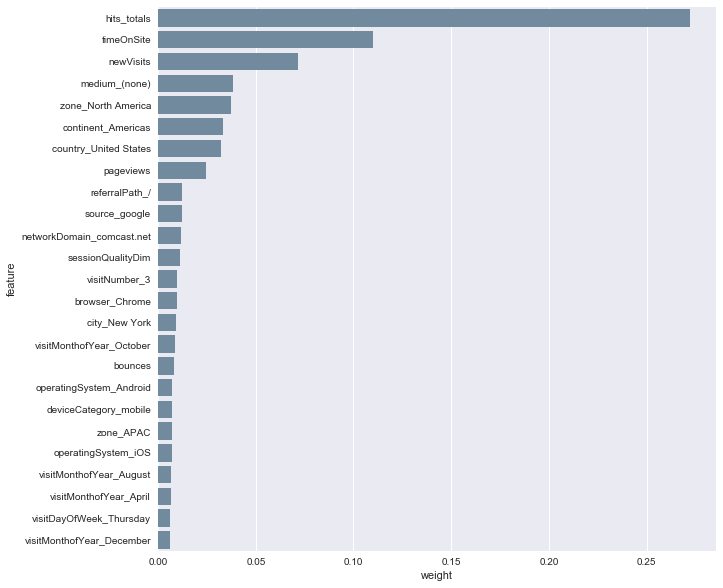

In [31]:
# need to do this part to get an inverse transform, so that we can get the feature names that were considered important
feat_clf = RandomForestClassifier()
feat_clf.fit(fsl.inverse_transform(X_train), y_train)

# plot out feature importance
feature_importance = pd.DataFrame(list(X.columns), columns=['feature'])
feature_importance['weight'] = feat_clf.feature_importances_
feature_importance = feature_importance.sort_values(by='weight', ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,10))
sns.barplot(x='weight', y='feature', data=feature_importance.head(25), color="#6b8ba4")
plt.show()

Below is the confusion matrix that is produced out of the test data set, as we can see on the bottom right, we managed to predict the majority of the visits that ended up in something being purchased.

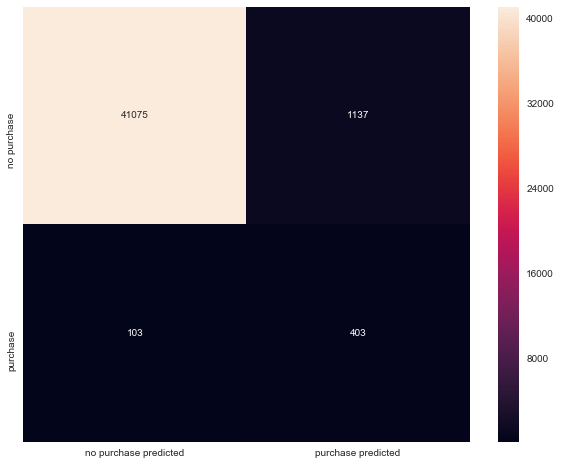

In [69]:
conf_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,
            fmt='',
            xticklabels =["no purchase predicted", "purchase predicted"],
            yticklabels =["no purchase", "purchase"])
plt.show()

## Regression Model

From our Classification Model, we were able to determine the most important features in labeling whether or not a purchase would be made for any given visit to the Google Merchandise Store. Since our feature space is extremely big, we decided to leverage this information for our Regression Model. We decided to use a Random Forest Regression because most of our features are binary which works well with decision tress. Also, Random Forest Regressors limit the number of features that are used per estimator which is ideal because we have such a large feature space. We utilized a GridSearchCV to find the ideal “max_depth”, “n_estimators”, “warm_start”, and “bootstrap” settings for our Random Forest Regression.

In [76]:
# These are the important features that we found in the Classification Model
# To save time, we manually typed out the features so the Classification Model doesn't have to be run

#important_features = ['hits_totals', 'timeOnSite', 'pageviews', 'zone_North America',
#                      'country_United States', 'subContinent_Northern America', 'sessionQualityDim',
#                      'bounces', 'continent_Americas', 'visitNumber_1', 'newVisits',
#                      'channelGrouping_Referral', 'deviceCategory_desktop', 'metro_(not set)',
#                      'source_(direct)', 'source_youtube.com', 'networkDomain_(not set)',
#                      'continent_Europe', 'deviceCategory_mobile', 'browser_Chrome', 'continent_Asia',
#                      'zone_EMEA', 'channelGrouping_Social', 'referralPath_/',
#                      'fullVisitorId', 'totalTransactionRevenue']

important_features = list(feature_importance.feature[0:25])
important_features.extend(['fullVisitorId', 'totalTransactionRevenue'])

# Create a data set for the regression based on only the the important features
RegData = train_clean[important_features].copy()
RegData['transactions'] = train_clean['transactions']
RegData['purchasePred'] = purchasePred

# Find all of the unique fullVisitorId from the df and store it into visitor_id_list
visitor_id_list = pd.Series(RegData.fullVisitorId.unique())
# Create a test set by randomly sampling 25% of the unique fullVisitorId from the list
# The random seed is set to 207 in honor of this class so that our data doesn't change.
test_visitor_id_list = visitor_id_list.sample(n=int(0.25 * len(visitor_id_list)), random_state=207)

# Create the training set by only pulling the fullVisitorIds that are not in test_visitor_id_list
X_train = RegData[~RegData.fullVisitorId.isin(test_visitor_id_list)]
y_train = X_train.totalTransactionRevenue

# Create the test set by only pulling the fullVisitorIds that are in the test_visitor_id_list
X_test = RegData[RegData.fullVisitorId.isin(visitor_id_list)]
y_test = X_test.totalTransactionRevenue

In [22]:
# We decided to use a RandomForest Regressor()
rdForest = RandomForestRegressor()

In [ ]:
# Define parameters we want to optimize for GridSearchCV
parameters = dict(max_depth = list(range(8,12,1)),
                  n_estimators = list(range(200,300,25)),
                  warm_start = [True, False],
                  bootstrap = [True, False])

# Fit and predict the best model parameters using GridSearchCV
grid_search = model_selection.GridSearchCV(rdForest,
                                           param_grid=parameters,
                                           scoring='neg_mean_squared_error')

# We want to drop fullVisitorId and totalTransactionRevenue before we fit the data
grid_search.fit(X_train.drop(['fullVisitorId', 'totalTransactionRevenue'], axis=1), y_train)

In [ ]:
# The our resulting best estimator
grid_search.best_estimator_

As shown above, our resulting best estimator has a max_depth of 8, n_estimators of 200, warm_start = False, and bootstrap = True.

In [77]:
# Create a new Random Forest Regressor with these ideal parameters
rdForest = RandomForestRegressor(max_depth=8, n_estimators=200, warm_start=False, bootstrap=True)

# Fit our resulting best Random Forest Regression with the training data
# We want to drop fullVisitorId and totalTransactionRevenue before we fit the data
rdForest.fit(X_train.drop(['fullVisitorId', 'totalTransactionRevenue'], axis=1), y_train)
             
# Now use that to predict the resulting 
X_test['predictedTransactionRevenue'] = rdForest.predict(X_test.drop(['fullVisitorId', 'totalTransactionRevenue'], axis=1))

## Aggregating Predictions

At this point, we have predicted the `totalTransactionRevenue` for each online visit to the Google Merchandise Store in our X_test data set and stored it as `predictedTransactionRevenue`. Now, we can aggregate the `predictedTransactionRevenue` by `fullVisitorId` and calculate the corresponding `predictedLogRevenue`. We will also aggregate the `totalTransactionRevenue` by `fullVisitorId` and calculate the corresponding `trueLogRevenue`. We will then test the RMSE between the `predictedLogRevenue` and the `trueLogRevenue`.

In [78]:
# Aggregate predictedTransactionRevenue per user grouped by fullVisitorId
predictedResults = X_test.groupby('fullVisitorId').predictedTransactionRevenue.sum().to_frame()

# Log the sum of revenue and store it as predictedLogRevenue
predictedResults['predictedLogRevenue'] = predictedResults.predictedTransactionRevenue + 1
predictedResults['predictedLogRevenue'] = predictedResults.predictedLogRevenue.apply(np.log)

In [79]:
# Aggregate totalTransactionRevenue per user grouped by fullVisitorId
trueResults = X_test.groupby('fullVisitorId').totalTransactionRevenue.sum().to_frame()

# Log the sum of revenue and store it as predictedLogRevenue
trueResults['trueLogRevenue'] = trueResults.totalTransactionRevenue + 1
trueResults['trueLogRevenue'] = trueResults.trueLogRevenue.apply(np.log)

Now that we have the `predictedLogRevenue` and the `trueLogRevenue`, we can calculate the RMSE between them.

<br>As a reminder, the Root Mean Squared Error (RMSE) is:

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y_i})^2}$$
where $\hat{y}$ is the predicted revenue for a customer for a customer and $y$ is the natural log of the actual summed revenue value plus one.

In [80]:
# First we calculate y_i = y_ihat
RMSE = trueResults['trueLogRevenue'] - predictedResults['predictedLogRevenue']
# Then we square the results
RMSE = np.square(RMSE)
# Then we calculate the mean
RMSE = np.mean(RMSE)
# Finally, we take the square root
RMSE = np.sqrt(RMSE)
RMSE

0.1391775159163254

As shown above, the RMSE score we ended up with is 0.1393. This would put us in position 554 on the Kaggle Leaderboard for this problem.

<img src='KaggleLeaderBoard.png'>

# Error Analysis and Lessons Learned:

We tried a lot of different methods and always ended up with subpar RMSE results.

First of all, we realized that the original data set was just way too big for us to do anything with on our laptops. We had to make the decision to randomly sample 10% of the original data set. This new data set was much more manageable, but still took a long time to run each code blocks.

The next thing we realized was that the features in our data set was just a mess. There were lots of improper NaN values, a lot of useless features, and some very complex embedded information that was difficult to extract. It was a very heavy undertaking to clean up the data set into one that we can build models with.

The next problem we ran across was a ridiculous feature space. There were so many features provided to us and they were all a mix of numeric and categorical data. We first deleted all of the useless features from our list and then we had to use the One Hot Encode method to create binarized feature columns for each of our categorical features.

We first tried to aggregate these features by `fullVisitorId` and then fitting it to various Regression Models but we couldn’t get the RMSE to be smaller than 1.7. Then we figured that rather than predicting how much revenue a certain `fullVisitorId` would contribute, it would make more sense to predict how much revenue is generated on each visit to the online Google Merchandise Store.

But before, we did that, we wanted to see if we can run a Classification Model to predict which visit to the store would generate a purchase. Upon doing this, we were able to identify which features were most important in the prediction.

Because of this discovery, we decided to only use these most important features to run a Random Forest Regression and figure out the `predictedTransactionRevenue`.  After we got these predictions, we aggregated the data on the test data set and ended up with our RMSE score.

# Conclusion:

In the end we came up with a RMSE score that was a lot higher than we expected. When we were building models that were trying to predict how much revenue each `fullVisitorId` would contribute and we couldn’t get an RMSE score lower than 1.7. As we racked our brains for solutions, we figured out that each individual may not make a purchase every time they visit the online store, and their meta data could be very different each time they visit the store as well. For example, maybe a person browses the store on his mobile at 2 am in the morning. The next day he browses the store again at 5 pm in the afternoon and this time makes a purchase. If we aggregated the data first by this person’s `fullVisitorId`, information about the time that the person made the purchase and the device he uses to make the purchase would be lost. It makes much more sense to try and determine whether or not the person would make a purchase and how much he will spend based on each of his visits. That way, Google can come up with some actionable strategies such as make the mobile user interface more appealing to try and get people to buy more from their phones, or put all their energy into advertising to people on their computer because they are more likely to buy things anyways.